In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



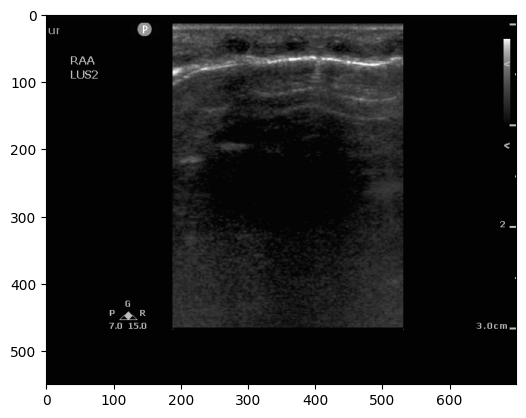

In [72]:

def extract_frame(video_path, frame_number=0):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # print(f"Total frames: {total_frames}")
    # print(f"FPS: {fps}")
    
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read frame
    ret, frame = cap.read()
    
    if not ret or frame is None:
        print("Error: Could not read frame.")
        return None, total_frames, fps
    
    # Release video capture object
    cap.release()

    return frame, total_frames, fps

video_path = '/cosma5/data/durham/dc-fras4/ultrasound/JCUH/038/JCUH_038_LUS_2_Supine/20240531_105025_0001.MP4'
frame, total_frames, fps = extract_frame(video_path, frame_number=0)

plt.imshow(frame)

scan_label_cut = frame[50:, 100:]
plt.imshow(scan_label_cut)


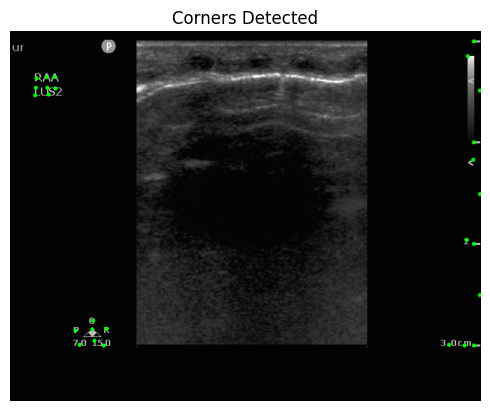

[[[143 442]]

 [[680  37]]

 [[139 467]]

 [[103 466]]

 [[652 466]]

 [[ 67  85]]

 [[689 165]]

 [[689  15]]

 [[689 316]]

 [[689 467]]

 [[125 460]]

 [[ 54  68]]

 [[ 66  68]]

 [[ 97 445]]

 [[ 39  70]]

 [[698 242]]

 [[698  88]]

 [[698 392]]

 [[678 310]]

 [[688 191]]

 [[123 430]]

 [[ 57  94]]

 [[122 443]]

 [[ 55  84]]

 [[675 467]]

 [[ 38  84]]

 [[ 37  95]]]


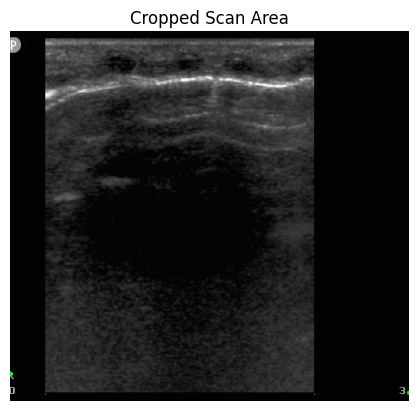

In [73]:
gray = cv2.cvtColor(scan_label_cut, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(
    gray,
    maxCorners=27,
    qualityLevel=0.01,
    minDistance=10,
    blockSize=3,
    useHarrisDetector=False,
    k=0.04
)

corners = np.intp(corners)  # Convert to integer coords
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(scan_label_cut, (x, y), radius=3, color=(0, 255, 0), thickness=-1)

plt.imshow(cv2.cvtColor(scan_label_cut, cv2.COLOR_BGR2RGB))
plt.title('Corners Detected')
plt.axis('off')
plt.show()

print(corners)
# crop to just scan area which is smallest rectangle containing all corners
x_coords = corners[:, 0, 0]
y_coords = corners[:, 0, 1]

h, w = scan_label_cut.shape[:2]
cx, cy = w / 2.0, h / 2.0

left  = x_coords[x_coords <= cx]
right = x_coords[x_coords >= cx]
top   = y_coords[y_coords <= cy]
bottom= y_coords[y_coords >= cy]

if left.size and right.size and top.size and bottom.size:
    x1 = int(np.max(left))     # nearest on the left
    x2 = int(np.min(right))    # nearest on the right
     # nearest below
else:
    # Fallback: use bounding box of all corners
    x1, x2 = int(np.min(x_coords)), int(np.max(x_coords))
    

y1, y2 = int(np.min(y_coords)), int(np.max(y_coords))

x1, x2 = sorted((max(0, x1), min(w, x2)))

if x2 - x1 < 2:
    x1 = max(0, int(cx) - 5); x2 = min(w, int(cx) + 5)

b=10

scan_area = scan_label_cut[y1-b:y2+b, x1:x2]



plt.imshow(cv2.cvtColor(scan_area, cv2.COLOR_BGR2RGB))
plt.title('Cropped Scan Area')
plt.axis('off')
plt.show()






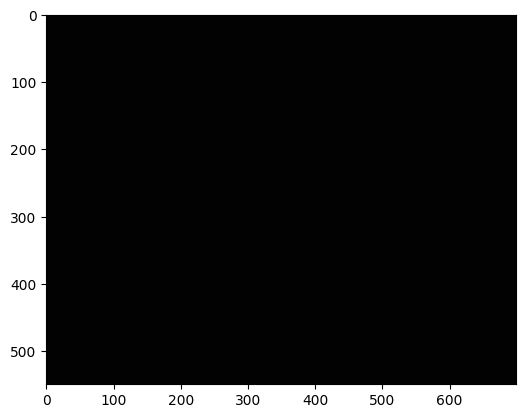

In [74]:
def fix_perspective(image):
    height, width = image.shape[:2]

    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # isolate image and missing region outlines
    mask = cv2.inRange(mask, 0, 1)
    

    # laplaciam edge detection
    mask = cv2.Laplacian(mask, cv2.CV_8U, ksize=7)

    # get straight edges (i.e. square xray image border)
    # extract contours (only need extreme outer contours)
    contours, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_SIMPLE)
    # method stores only contour endpoints rather than all points on contour

    # create mask for ROI (xray image) outline (square)
    square_mask = np.zeros((height, width), np.uint8)
    cv2.drawContours(square_mask, contours, -1, (255, 255, 255), 1)

    # get 4 corners of xray image using Shi-Tomasi method (through OpenCV)
    corners = cv2.goodFeaturesToTrack(square_mask, 4, 0.01, 10)
    corners = corners.reshape(4, 2)

    border_width = 4  # border around image (set = 0 for no border)

    # desired 4 corners after warp
    map_to = [[border_width, border_width],
              [width-border_width, border_width],
              [border_width, height-border_width],
              [width-border_width, height-border_width]]
    map_from = [[0., 0.]] * 4  # to store 4 corners of ROI

    # sort corners of ROI to align with corners of frame
    # such that map_from[i] is closest corner to map_to[i]
    for i in range(len(map_to)):  # iterate through map_to
        min_dist = float('inf')
        # for each corner found by Shi-Tomasi:
        for c in corners:
            # use numpy to get euclidean distance (l2 norm) between 2 points
            dist = np.linalg.norm(c - map_to[i])
            if dist < min_dist:
                # update closest corner to map_to[i]
                min_dist = dist
                map_from[i] = c  # i.e. c is closest corner to map_to[i] found

    # shift perspective using perspective transform
    M = cv2.getPerspectiveTransform(
        np.array(map_from, np.float32), np.array(map_to, np.float32))
    
    # NB only need to run this one line for every frame after calculating M for first frame
    image = cv2.warpPerspective(image, M, (width, height))

    return image

plt.imshow(fix_perspective(scan_label_cut))


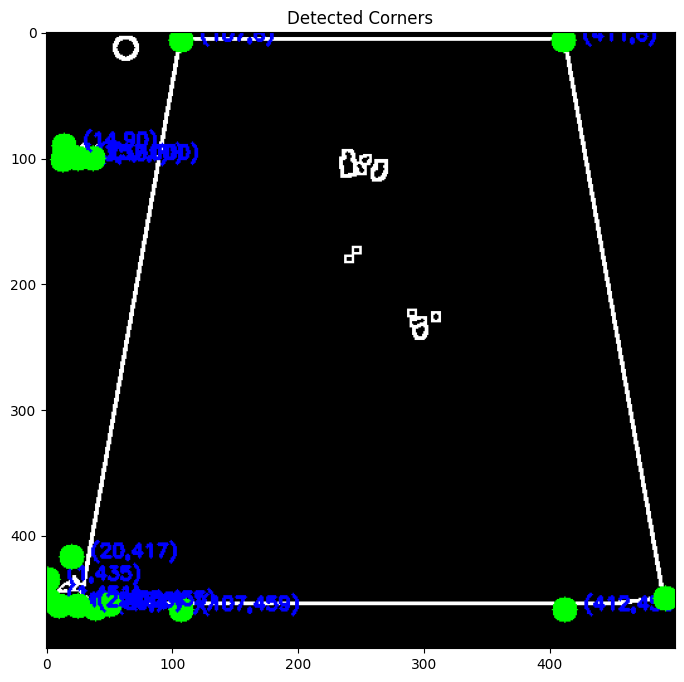

In [86]:
scan_label_cut_1 = scan_label_cut[10:500, 100:600]
mask = cv2.cvtColor(scan_label_cut_1, cv2.COLOR_BGR2GRAY)
# mask = cv2.GaussianBlur(mask, (5, 5), 0)

height, width = scan_label_cut_1.shape[:2]
    # isolate image and missing region outlines
mask = cv2.inRange(mask, 0, 10)
mask = cv2.Laplacian(mask, cv2.CV_8U, ksize=7)
contours, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_SIMPLE)

# create mask for ROI (xray image) outline (square)
square_mask = np.zeros((height, width), np.uint8)
cv2.drawContours(square_mask, contours, -1, (255, 255, 255), 1)

# get 4 corners of xray image using Shi-Tomasi method (through OpenCV)
n_corn = 16
corners = cv2.goodFeaturesToTrack(square_mask, n_corn, 0.01, 10)
corners = corners.reshape(n_corn, 2)

# Visualize corners on the original image
vis_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
for corner in corners:
    x, y = corner.astype(int)
    cv2.circle(vis_image, (x, y), 10, (0, 255, 0), -1)  # Green circles
    cv2.putText(vis_image, f'({x},{y})', (x+15, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Corners')
plt.show()

# border_width = 4  # border around image (set = 0 for no border)

# # desired 4 corners after warp
# map_to = [[border_width, border_width],
#             [width-border_width, border_width],
#             [border_width, height-border_width],
#             [width-border_width, height-border_width]]
# map_from = [[0., 0.]] * 4  # to store 4 corners of ROI

# # sort corners of ROI to align with corners of frame
# # such that map_from[i] is closest corner to map_to[i]
# for i in range(len(map_to)):  # iterate through map_to
#     min_dist = float('inf')
#     # for each corner found by Shi-Tomasi:
#     for c in corners:
#         # use numpy to get euclidean distance (l2 norm) between 2 points
#         dist = np.linalg.norm(c - map_to[i])
#         if dist < min_dist:
#             # update closest corner to map_to[i]
#             min_dist = dist
#             map_from[i] = c  # i.e. c is closest corner to map_to[i] found


# plt.imshow(mask, cmap='gray')

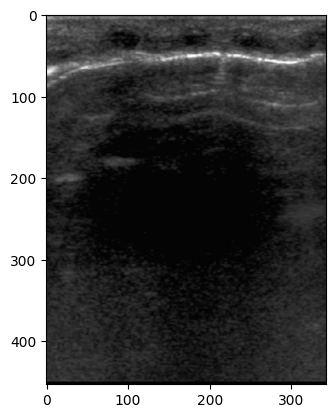

In [78]:
y1=11
y2=464
x1=45
x2=388

final_crop = scan_area[y1:y2, x1:x2]
plt.imshow(cv2.cvtColor(final_crop, cv2.COLOR_BGR2RGB))

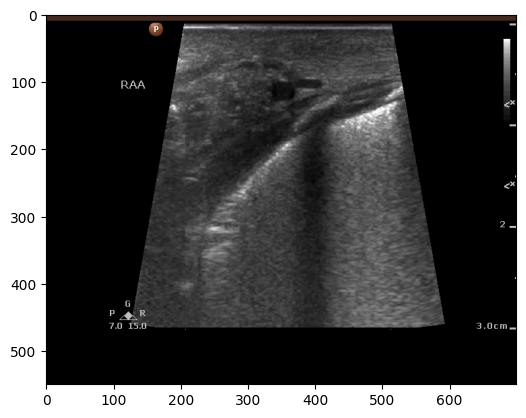

In [82]:
image_path='/cosma5/data/durham/dc-fras4/ultrasound/JCUH/003/JCUH003_LUS_1/20230522_121100_0001.AVI'

frame, total_frames, fps = extract_frame(image_path, frame_number=0)


scan_label_cut = frame[50:, 100:]
plt.imshow(scan_label_cut)

cropped_area = scan_label_cut[y1:y2, x1:x2]
# plt.imshow(cropped_area)